In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
planet_mass = 5 * u.M_earth.to(u.M_sun)
planet_ecc = 0.01
planet_radius = 2.5 * u.R_earth.to(u.AU)
star_radius = 1.0 * u.R_sun.to(u.AU)
planet_mass, planet_radius

(1.5017446744253966e-05, 0.00010658741281135093)

In [3]:
# set up rebound
sim = rebound.Simulation()
sim.G = 1.
sim.add(m=1., r=star_radius, hash="star")
sim.add(m=planet_mass, a=0.17, 
        e=planet_ecc, r=planet_radius, hash="p1")
sim.add(m=planet_mass, a=0.23,
        e=planet_ecc, r=planet_radius, hash="p2")
sim.move_to_com()

# using WHFast with planet period = planet period / 12.134
ps = sim.particles
sim.integrator = "whfast"
sim.dt = ps[1].P / 12.1234

# add migration forces with characteristic timescales
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
τ1 = 5. * u.Myr.to(u.yr) * (2 * np.pi)
τ2 = τ1 / 1.1
ps[1].params["tau_a"] = -τ1
ps[2].params["tau_a"] = -τ2
rebx.add_force(mof)

In [131]:
# integrate until 4 millions years
tmax = 4e6
N_outputs = 100

# set up arrays to store orbital elements
# 2 pi factors are to convert from yr to yr/2pi units

# here, we're integrating half of the way first
# then switch off migration forces
t_arr = np.linspace(0., tmax / 2, N_outputs // 2) * (2*np.pi)

# storing semimajor axis, eccentricity, and inclination
a = np.zeros((N_outputs,2))
ecc = np.zeros((N_outputs,2))
inc = np.zeros((N_outputs,2))

# storing obliquity
obliquity = np.zeros((N_outputs,2))

for i, t in enumerate(t_arr):
    print(f"Current sim time: {t}; % complete: {np.round(t/(tmax*2*np.pi), 2)*100}")
    sim.integrate(t, exact_finish_time=1)
    
    ps = sim.particles
    a[i] = [ps[1].a, ps[2].a]
    ecc[i] = [ps[1].e, ps[2].e]
    inc[i] = [ps[1].inc, ps[2].inc]

# switch off migration
ps[1].params["tau_a"] = np.inf
ps[2].params["tau_a"] = np.inf

# integrate the rest of the way
t_arr = np.linspace(tmax / 2, tmax, N_outputs // 2) * (2*np.pi)

for i, t in enumerate(t_arr):
    print(f"Current sim time: {t}; % complete: {np.round(t/(tmax*2*np.pi), 2)*100}")
    sim.integrate(t, exact_finish_time=1)

    ps = sim.particles
    a[i + N_outputs // 2] = [ps[1].a, ps[2].a]
    ecc[i + N_outputs // 2] = [ps[1].e, ps[2].e]
    inc[i + N_outputs // 2] = [ps[1].inc, ps[2].inc]

Current sim time: 0.0; % complete: 0.0
Current sim time: 256456.5431501872; % complete: 1.0
Current sim time: 512913.0863003744; % complete: 2.0
Current sim time: 769369.6294505616; % complete: 3.0
Current sim time: 1025826.1726007488; % complete: 4.0
Current sim time: 1282282.7157509362; % complete: 5.0
Current sim time: 1538739.2589011232; % complete: 6.0
Current sim time: 1795195.8020513104; % complete: 7.000000000000001
Current sim time: 2051652.3452014977; % complete: 8.0
Current sim time: 2308108.888351685; % complete: 9.0
Current sim time: 2564565.4315018724; % complete: 10.0
Current sim time: 2821021.9746520594; % complete: 11.0
Current sim time: 3077478.5178022464; % complete: 12.0
Current sim time: 3333935.0609524343; % complete: 13.0
Current sim time: 3590391.604102621; % complete: 14.000000000000002
Current sim time: 3846848.147252808; % complete: 15.0
Current sim time: 4103304.6904029953; % complete: 16.0
Current sim time: 4359761.233553183; % complete: 17.0
Current sim ti

(0.0, 0.25)

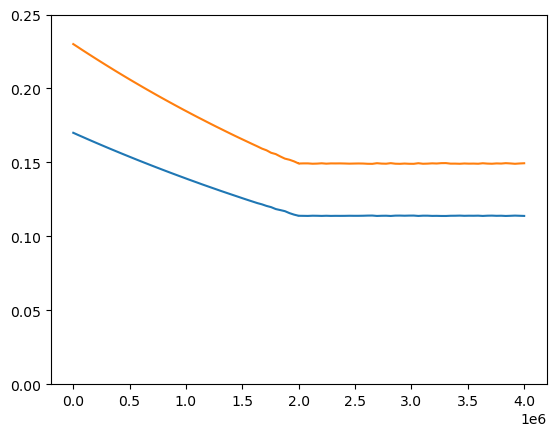

In [136]:
t_plot = list(np.linspace(0., tmax / 2, N_outputs // 2)) + list(np.linspace(tmax / 2, tmax, N_outputs // 2))

plt.plot(t_plot, a[:,0])
plt.plot(t_plot, a[:,1])

plt.ylim([0., 0.25])

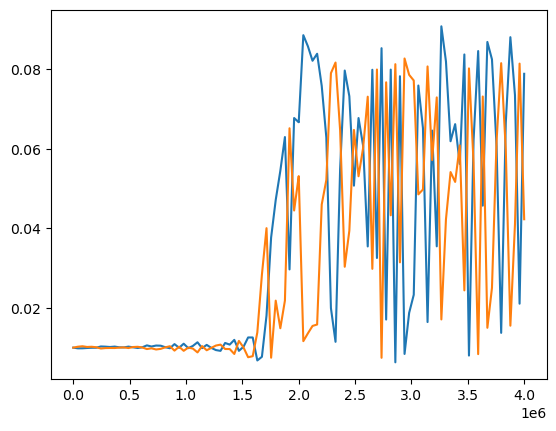

In [137]:
plt.plot(t_plot, ecc[:,0])
plt.plot(t_plot, ecc[:,1])

Now migration + obliquity evolution + equilibrium tides

intro to equilibrium tides

In [22]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [30]:
planet_mass = 5 * u.M_earth.to(u.M_sun)
planet_ecc = 0.01
planet_radius = 2.5 * u.R_earth.to(u.AU)
star_radius = 1. * u.R_sun.to(u.AU)
planet_mass, planet_radius

(1.5017446744253966e-05, 0.00010658741281135093)

In [31]:
# set up rebound
sim = rebound.Simulation()
sim.G = 1.
sim.add(m=1., r=star_radius, hash="star")
sim.move_to_com()
sim.add(m=planet_mass, a=0.17, 
        e=planet_ecc, r=planet_radius, hash="p1")
sim.add(m=planet_mass, a=0.23,
        e=planet_ecc, r=planet_radius, hash="p2")


# using WHFast with planet period = planet period / 12.134
ps = sim.particles
sim.integrator = "whfast"
sim.dt = ps[1].P / 12.1234

# add migration forces with characteristic timescales
rebx = reboundx.Extras(sim)
# mof = rebx.load_force("modify_orbits_forces")
# τ1 = 5. * u.Myr.to(u.yr) * (2 * np.pi)
# τ2 = τ1 / 1.1
# ps[1].params["tau_a"] = -τ1
# ps[2].params["tau_a"] = -τ2
# rebx.add_force(mof)


In [32]:
sf = rebx.load_force("tides_spin")
rebx.add_force(sf)

# Star parameters
# Stellar rotation period = 20 days
C_star = 0.07 # normalized moment of inertia
ps[0].params['Omega'] = rebound.spherical_to_xyz(magnitude=2*np.pi/(20/365), theta=0., phi=0.)
ps[0].params['I'] = C_star * ps[0].m * ps[0].r**2

# Planet parameters
C_planet = 0.25 # normalized moment of inertia
Prot_planet1 = 5 # days
initial_obliquity = 1 # degrees
ps[1].params['Omega'] = rebound.spherical_to_xyz(magnitude=2*np.pi/(Prot_planet1/365), theta=np.radians(initial_obliquity), phi=0.)
ps[1].params['I'] = C_planet * ps[1].m * ps[1].r**2

Prot_planet2 = 3 #days
ps[2].params['Omega'] = rebound.spherical_to_xyz(magnitude=2*np.pi/(Prot_planet2/365), theta=np.radians(initial_obliquity), phi=0.)
ps[2].params['I'] = C_planet * ps[2].m * ps[2].r**2

In [33]:
# initialize spin ODEs
rebx.initialize_spin_ode(sf)

In [35]:
# Set k2 Love numbers so planets feel tides and deform from perfect spheres
ps[0].params['k2'] = 0.1
ps[1].params['k2'] = 0.4
ps[2].params['k2'] = 0.4

In [36]:
ps = sim.particles

Omega_planet1 = ps[1].params["Omega"]
Omega_planet2 = ps[2].params["Omega"]
rot1 = rebound.Rotation.to_new_axes(newz=ps[1].hvec)
rot2 = rebound.Rotation.to_new_axes(newz=ps[2].hvec)
Omega_planet1_orbit = rot1 * Omega_planet1
Omega_planet2_orbit = rot2 * Omega_planet2
_, theta1, _ = rebound.xyz_to_spherical(Omega_planet1_orbit)
_, theta2, _ = rebound.xyz_to_spherical(Omega_planet2_orbit)

theta1, theta2

(0.017453292519947913, 0.017453292519941554)

In [38]:
# integrate until 4 millions years
tmax = 4e6
N_outputs = 100

# set up arrays to store orbital elements
# 2 pi factors are to convert from yr to yr/2pi units
# here, we're integrating half of the way first
# then switch off migration forces
t_arr = np.linspace(0., tmax / 2, N_outputs // 2) * (2*np.pi)

# storing semimajor axis, eccentricity, and inclination
a = np.zeros((N_outputs,2))
ecc = np.zeros((N_outputs,2))
inc = np.zeros((N_outputs,2))

# storing obliquity
obliquity = np.zeros((N_outputs,2))

for i, t in enumerate(t_arr):
    print(f"Current sim time: {t}; % complete: {np.round(t/(tmax*2*np.pi), 2)*100}")
    sim.integrate(t)
    
    ps = sim.particles
    a[i] = [ps[1].a, ps[2].a]
    ecc[i] = [ps[1].e, ps[2].e]
    inc[i] = [ps[1].inc, ps[2].inc]
    
    Omega_planet1 = ps[1].params["Omega"]
    Omega_planet2 = ps[2].params["Omega"]
    rot1 = rebound.Rotation.to_new_axes(newz=ps[1].hvec)
    rot2 = rebound.Rotation.to_new_axes(newz=ps[2].hvec)
    Omega_planet1_orbit = rot1 * Omega_planet1
    Omega_planet2_orbit = rot2 * Omega_planet2
    _, theta1, _ = rebound.xyz_to_spherical(Omega_planet1_orbit)
    _, theta2, _ = rebound.xyz_to_spherical(Omega_planet2_orbit)
    
    obliquity[i] = [np.degrees(theta1), np.degrees(theta2)]

# switch off migration
ps[1].params["tau_a"] = np.inf
ps[2].params["tau_a"] = np.inf

# integrate the rest of the way
t_arr = np.linspace(tmax / 2, tmax, N_outputs // 2) * (2*np.pi)

for i, t in enumerate(t_arr):
    print(f"Current sim time: {t}; % complete: {np.round(t/(tmax*2*np.pi), 2)*100}")
    sim.integrate(t)
    
    ps = sim.particles
    a[i + N_outputs // 2] = [ps[1].a, ps[2].a]
    ecc[i + N_outputs // 2] = [ps[1].e, ps[2].e]
    inc[i + N_outputs // 2] = [ps[1].inc, ps[2].inc]
    
    Omega_planet1 = ps[1].params["Omega"]
    Omega_planet2 = ps[2].params["Omega"]
    rot1 = rebound.Rotation.to_new_axes(newz=ps[1].hvec)
    rot2 = rebound.Rotation.to_new_axes(newz=ps[2].hvec)
    Omega_planet1_orbit = rot1 * Omega_planet1
    Omega_planet2_orbit = rot2 * Omega_planet2
    _, theta1, _ = rebound.xyz_to_spherical(Omega_planet1_orbit)
    _, theta2, _ = rebound.xyz_to_spherical(Omega_planet2_orbit)
    
    obliquity[i + N_outputs//2] = [np.degrees(theta1), np.degrees(theta2)]

Current sim time: 0.0; % complete: 0.0
Current sim time: 256456.5431501872; % complete: 1.0
Current sim time: 512913.0863003744; % complete: 2.0


KeyboardInterrupt: 